# Lagrangian Neural Networks

In this tutorial we take a look at **Lagrangian Neural Networks** (LNNs) [Cranmer M., et al., 2020](https://arxiv.org/abs/2003.04630) which, together with HNNs [link a notebook]() [Greydanus S., et al., 2019](https://arxiv.org/abs/1906.01563) represent the latest learning paradigm to discover symmetries and conservation laws from data.

Let $\mathcal{Q}\subset\mathbb{R}^n$ be a smooth manifold anf let $q\in\mathcal{Q}$ be a vector of generalized coordinates. The Lagrangian function $\mathcal{L}:\mathcal{TQ}\rightarrow\mathbb{R}$ is defined on the tangent bundle $\mathcal{TQ}$ of the configuration manifold $\mathcal{Q}$ (if $\mathcal{Q}=\mathbb{R}^n$, then $\mathcal{TQ}$ is diffeomorphic to $\mathbb{R}^{2n}$), i.e. the Lagrangian is a function of the configurations $q$ and their velocities $\dot q$. 

Derived from the calculus of variations, the Euler-Lagrange equations of motions can be generally explicitly written as a second--order ordinary differential equation:

$$
    \ddot q = \left(\nabla_{\dot q} \nabla_{\dot q}^\top \mathcal{L}\right)^{-1}\left[\nabla_q\mathcal{L} - \left(\nabla_q\nabla^\top_{\dot q}\mathcal L\right)\dot q\right]
$$

**Lagrangian Neural Networks** try to mimick Euler-Lagrange equations by learning from data a Lagrangian $\mathcal{L}_\theta$ parametriezed by a *neural network* (with parameters $\theta$). 

When a net of tuples $\{(q_k,\dot q_k, \ddot q_k)\}_{k=1,\dots,K}$ generated by some conservative dynamical process is available, LNNs are trained to learn the Lagrangian from the data by minimizing, e.g. the *MSE loss*:
$$
    \min_{\theta}\frac{1}{K}\sum_{k=1}^K\left\|\ddot q_k - \left(\nabla_{\dot q} \nabla_{\dot q}^\top \mathcal{L}_\theta(q_k, \dot q_k)\right)^{-1}\left[\nabla_q\mathcal{L}_\theta(q_k, \dot q_k) - \left(\nabla_q\nabla^\top_{\dot q}\mathcal L_\theta(q_k, \dot q_k)\right)\dot q_k\right]\right\|_2^2
$$


We hereby showcase the torchdyn implementation of LNNs.

In [1]:
import sys
sys.path.append('../')
from torchdyn.models import *; from torchdyn.data_utils import *
from torchdyn import *

The vector field of an HNN, to be passed to our `DEFunc` can be simply defined as follows

In [2]:
import torch
import torch.nn as nn
from torch.autograd.functional import jacobian as jacobian
from torch.autograd.functional import hessian as hessian
from functools import partial

class fLNN(nn.Module):
    def __init__(self, L, f):
        super().__init__()
        self.L = L
        self.f = f
    def forward(self, x):
        self.n = n = x.shape[1]//2 ; bs = x.shape[0]    
        x = torch.autograd.Variable(x, requires_grad=True)
        qqd_batch = tuple(x[i, :] for i in range(bs))
        jac = tuple(map(partial(jacobian, self._lagrangian, create_graph=True), qqd_batch))
        hess = tuple(map(partial(hessian, self._lagrangian, create_graph=True), qqd_batch))
        qdd_batch = tuple(map(self._qdd, zip(jac, hess, qqd_batch)))
        qd, qdd = x[:, n:], torch.cat([qdd[None] for qdd in qdd_batch])
        return torch.cat([qd, qdd], 1)
    
    def _lagrangian(self, qqd):
        return L(qqd).sum()
    
    def _qdd(self, inp):
        n = self.n ; jac, hess, qqd = inp
        return hess[n:, n:].pinverse()@(jac[:n] - hess[n:, :n]@qqd[n:] + self.f(qqd))

We consider a 1D mass-spring system

$$
    m\ddot x - kx = 0,~~x(0)=0,~~\dot x(0)=1
$$

and we let $q=x$, $p=\dot x$. We then train the neural network on data generated from a single trajectory of the system


## "Static" Training

In [22]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

m, k, b = 1, 1, 1
X = torch.randn(1000,2).to(device)
Xdd = -k*X[:,0]/m - b*X[:,1]/m

bs = 50
train = data.TensorDataset(X, Xdd)
trainloader = data.DataLoader(train, batch_size=bs, shuffle=False)

In [23]:
import pytorch_lightning as pl

class LNNLearner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model.defunc(0, x)
    
    def loss(self, y_hat, y):
        return ((y - y_hat[:,1])**2).mean()
    
    def training_step(self, batch, batch_idx):
        x = torch.randn(10,2).to(device)
        y = -(k*x[:,0] + b*x[:,1])/m
        
        y_hat = self.model.defunc(0, x)
        loss = self.loss(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.0001)

    def train_dataloader(self):
        return trainloader

In [24]:
L = nn.Sequential(
            nn.Linear(2,64),
            nn.Softplus(),
            nn.Linear(64,64),
            nn.Softplus(),
            nn.Linear(64,1)).to(device)

f = nn.Sequential(
            nn.Linear(2,64),
            nn.Softplus(),
            nn.Linear(64,1)).to(device)

model = NeuralDE(func=fLNN(L, f)).to(device)

In [30]:
learn = LNNLearner(model)
trainer = pl.Trainer(min_nb_epochs=500, max_nb_epochs=1000)
trainer.fit(learn)

INFO:lightning:
   | Name               | Type       | Params
----------------------------------------------
0  | model              | NeuralDE   | 4 K   
1  | model.defunc       | DEFunc     | 4 K   
2  | model.defunc.m     | fLNN       | 4 K   
3  | model.defunc.m.L   | Sequential | 4 K   
4  | model.defunc.m.L.0 | Linear     | 192   
5  | model.defunc.m.L.1 | Softplus   | 0     
6  | model.defunc.m.L.2 | Linear     | 4 K   
7  | model.defunc.m.L.3 | Softplus   | 0     
8  | model.defunc.m.L.4 | Linear     | 65    
9  | model.defunc.m.f   | Sequential | 257   
10 | model.defunc.m.f.0 | Linear     | 192   
11 | model.defunc.m.f.1 | Softplus   | 0     
12 | model.defunc.m.f.2 | Linear     | 65    


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)
INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [7]:
## Evaluate 
import time

In [26]:
t = time.time()

X0 = torch.randn(100, 2).to(device)
s_span = torch.linspace(0, 1, 20)
traj = model.trajectory(X0, s_span)

print(time.time() - t)

100.68477988243103


In [27]:
traj = traj.cpu().detach()

Text(0.5, 1.0, "HHN's trajectories & training data")

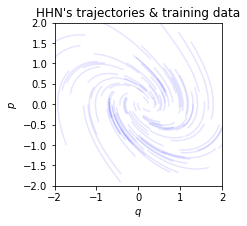

In [28]:
# Plot the HHN's trajectories with random ICs
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
color = ['orange', 'blue']
for i in range(len(X0)):
    ax.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=0.1);
#ax.scatter(X[:,0].cpu(),X[:,1].cpu(), color='red')
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("HHN's trajectories & training data")

Text(0.5, 1.0, 'Learned Hamiltonian & Vector Field')

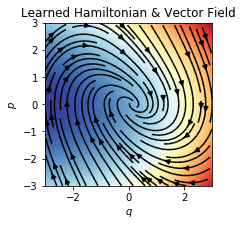

In [29]:
n_grid =  50
x = torch.linspace(-3,3,n_grid)
Q, P = torch.meshgrid(x,x)
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)
for i in range(n_grid):
    for j in range(n_grid):
        x = torch.cat([Q[i,j].reshape(1,1),P[i,j].reshape(1,1)],1).to(device)
        H[i,j] = model.defunc.m.L(x).detach().cpu()
        O = model.defunc(0,x).detach().cpu()
        U[i,j], V[i,j] = O[0,0], O[0,1]
        
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.contourf(Q,P,H,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),P.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([P.min(),P.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Learned Hamiltonian & Vector Field")

## HNNs as General-Purpose Modules

If we want to try using using an HNN as a general-purpose DL module, e.g. for a classification task, you can do it well in `torchdyn`. Let us introduce a simple toy example

**Data**

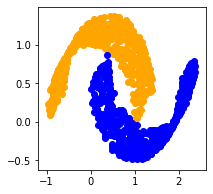

In [81]:
# Generate data with torchdyn utilities
d = ToyDataset()
X, yn = d.generate(n_samples=1000, dataset_type='moons', noise=.4)    

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [160]:
# Load data into dataloader
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)

train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X)//50, shuffle=True)

**Learner**

In [161]:
# Define Learner - we will use MSE Loss
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.0001)

    def train_dataloader(self):
        return trainloader

In [157]:
# Define Hamiltonian and DEFunc
L = nn.Sequential(
        nn.Linear(4,64),
        nn.Linear(64,1)    
).to(device)

f = nn.Linear(4,1).to(device)

In [158]:
# Define Neural ODE with Hamiltonian vector field 
model = nn.Sequential(
            nn.Linear(2,4),
            NeuralDE(fLNN(L, f)),
            nn.Linear(4,2)).to(device)
# We append a linear out layer after NeuralDE to use MSE Loss

In [162]:
# Train HNN
learn = Learner(model)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:
  | Name                 | Type       | Params
------------------------------------------------
0 | model                | Sequential | 412   
1 | model.0              | Linear     | 12    
2 | model.1              | NeuralDE   | 390   
3 | model.1.defunc       | DEFunc     | 390   
4 | model.1.defunc.m     | fLNN       | 390   
5 | model.1.defunc.m.L   | Sequential | 385   
6 | model.1.defunc.m.L.0 | Linear     | 320   
7 | model.1.defunc.m.L.1 | Linear     | 65    
8 | model.1.defunc.m.f   | Linear     | 5     
9 | model.2              | Linear     | 10    


INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

**Plot Trajectories in the phase space**

In [165]:
s_span = torch.linspace(0, 1, 100)
traj = model[1].trajectory(model[0](X_train), s_span).detach().cpu()

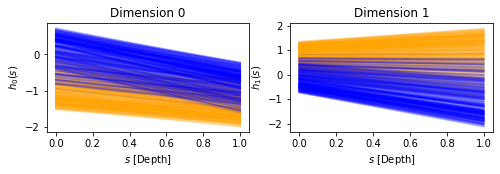

In [166]:
plot_2D_depth_trajectory(s_span, traj, yn, len(X))

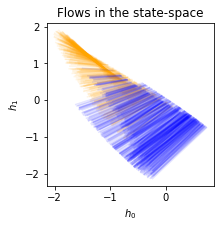

In [167]:
plot_2D_state_space(traj, yn, len(X))

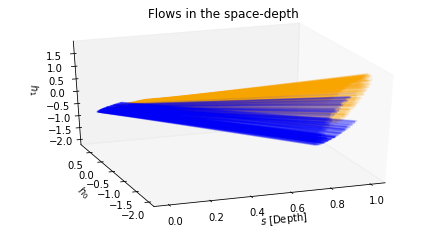

In [168]:
plot_2D_space_depth(s_span, traj, yn, len(X))

**Plot Learned Hamiltonian Function over vector field**

Text(0.5, 1.0, 'Learned Hamiltonian & Vector Field')

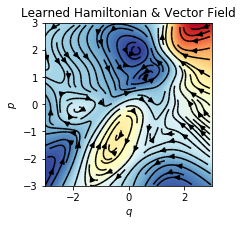

In [19]:
n_grid =  50
x = torch.linspace(-3,3,n_grid)
Q, P = torch.meshgrid(x,x)
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)
for i in range(n_grid):
    for j in range(n_grid):
        x = torch.cat([Q[i,j].reshape(1,1),P[i,j].reshape(1,1)],1).to(device)
        H[i,j] = model[0].defunc.m[0].H(x).detach().cpu()
        O = model[0].defunc(0,x).detach().cpu()
        U[i,j], V[i,j] = O[0,0], O[0,1]
        
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.contourf(Q,P,H,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),P.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([P.min(),P.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Learned Hamiltonian & Vector Field")